In [1]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import DataLoader
from scipy.io import loadmat
import numpy as np

from models.segmentation import Unet3DSeg
from models.energy import ShapeEnergyModel
from dataset import MRI_2D_Dataset_Classifier, im_normalize

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
model_energy = ShapeEnergyModel.load('./checkpoints/unet_acdc_energy.pt', device)
model_energy.to(device)
model_energy.eval()

ShapeEnergyModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (classifier_head): Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [3]:
model_seg = Unet3DSeg(numclasses=3, inshape=(256,256)).load('./checkpoints/unet_acdc_seg.pt', device)
model_seg.to(device)
model_seg.eval()

Unet3DSeg(
  (unet_model): Unet(
    (encoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
          (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
          (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
          (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (3): ModuleList(
        (0): Co

In [4]:
def configure_model(model):
    """Configure model for use with tent."""
    # train mode, because tent optimizes the model to minimize entropy
    model.train()
    # disable grad, to (re-)enable only what tent updates
    model.requires_grad_(False)
    # configure norm for tent updates: enable grad + force batch statisics
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.requires_grad_(True)
            # force use of batch stats in train and eval modes
            m.track_running_stats = False
            m.running_mean = None
            m.running_var = None
    return model


model_seg = configure_model(model_seg)

In [5]:
test_set = MRI_2D_Dataset_Classifier('./example_data')
batch_size = 24
test_set = DataLoader(test_set, batch_size=batch_size, shuffle=False)

for inputs_test, masks_test, labels_test in tqdm(test_set):
    # print('inputs shape', inputs_test.shape)
    inputs_test = inputs_test.to(device)
    masks_test = masks_test.to(device)
    labels_test = labels_test.to(device) # labels_test shape B x 1 (binary label)
    # convert tensor type to float
    inputs_test = inputs_test.float()
    masks_test = masks_test.float()
    labels_test = labels_test.float()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


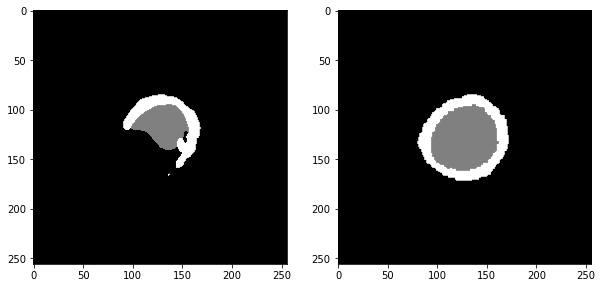

In [6]:
y_preds = model_seg(inputs_test)

softmax_fn = nn.Softmax(dim=1)

y_preds_prob = softmax_fn(y_preds).float()
y_preds_prob_org = y_preds_prob.detach().clone() # keep a copy of the original prediction

sample_idx = 12


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
im1 = axes[0].imshow(y_preds_prob[sample_idx].argmax(dim=0).detach().cpu().numpy(), cmap='gray')
im2 = axes[1].imshow(masks_test[sample_idx].permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
plt.show()

In [7]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
# Target label for inversion (e.g., class 0)
n_blocks = 16

target_label = torch.zeros((batch_size, 1, n_blocks, n_blocks))
optimizer = torch.optim.Adam([p for p in model_seg.parameters() if p.requires_grad], lr=1e-2)

criterion_viz = nn.BCEWithLogitsLoss(reduction='none')
target  = target_label.view(batch_size, 1, n_blocks, n_blocks).float()
target = target.to(device)

sigmoid_fn = nn.Sigmoid()

output_list = []
output_score_list = []

# Model inversion loop
for iteration in range(10):  # Number of iterations for optimization
    optimizer.zero_grad()

    y_preds = model_seg(inputs_test)

    softmax_fn = nn.Softmax(dim=1)
    y_preds_prob = softmax_fn(y_preds)

    y_preds_prob = y_preds_prob.float()

    # Forward pass: Get the model's predictions for the generated image
    output = model_energy(y_preds_prob)

    loss_region =  - criterion_viz(output, target)
    loss = torch.mean(loss_region) 

    # Backward pass: Compute gradients of the input image
    loss.backward()

    # Update the input image
    optimizer.step()

    output_list.append(y_preds_prob[sample_idx].detach().cpu().numpy())
    output_score_list.append(output[sample_idx].detach().cpu().numpy())


    print(f"Iteration {iteration}, Loss: {loss.item()}")
       

Iteration 0, Loss: -6.542713165283203
Iteration 1, Loss: -7.059146881103516
Iteration 2, Loss: -7.3044352531433105
Iteration 3, Loss: -7.549223899841309
Iteration 4, Loss: -7.725624084472656
Iteration 5, Loss: -7.893962860107422
Iteration 6, Loss: -8.040725708007812
Iteration 7, Loss: -8.25761890411377
Iteration 8, Loss: -8.523124694824219
Iteration 9, Loss: -8.844095230102539


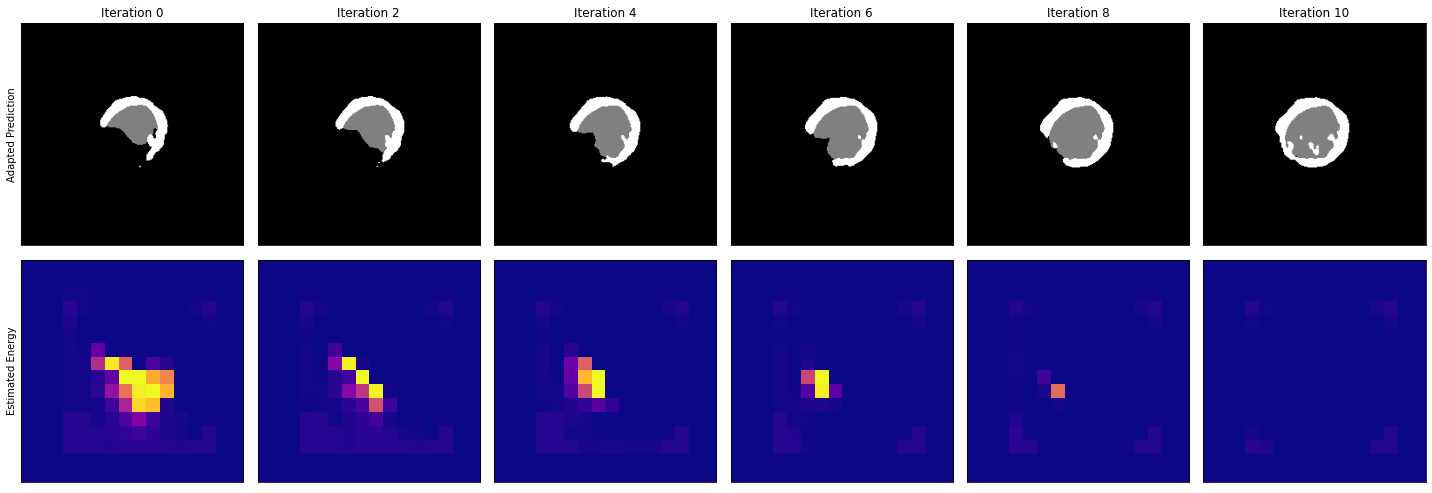

In [8]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))


fig, axes = plt.subplots(2, 6, figsize=(20, 7))


axes[0, 0].imshow(output_list[0].argmax(0).squeeze(), cmap='gray')
axes[0 ,0].set_xticks([])
axes[0, 0].set_yticks([])
axes[0, 0].set_ylabel('Adapted Prediction')
axes[0, 0].set_title('Iteration 0')

axes[1, 0].imshow(1-sigmoid(output_score_list[0].squeeze()), cmap='plasma', vmax=1, vmin=0)
axes[1 ,0].set_xticks([])
axes[1, 0].set_yticks([])
axes[1, 0].set_ylabel('Estimated Energy')

for i in range(5):
    index = 2 * i + 1

    axes[0, i+1].imshow(output_list[index].argmax(0).squeeze(), cmap='gray')
    axes[0 ,i+1].set_xticks([])
    axes[0, i+1].set_yticks([])
    axes[0, i+1].set_title(f'Iteration {index + 1}')

    axes[1, i+1].imshow(1-sigmoid(output_score_list[index].squeeze()), cmap='plasma', vmax=1, vmin=0)
    axes[1 ,i+1].set_xticks([])
    axes[1, i+1].set_yticks([])

plt.tight_layout()
plt.show()